In [1]:
import torch
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

from dataset import MyData
from model import Net
from config import device

PATH_TO_DATASET = './CloC/'
IMG_SIZE = (217, 334)

Selected devie is cuda:0


## Pretraining

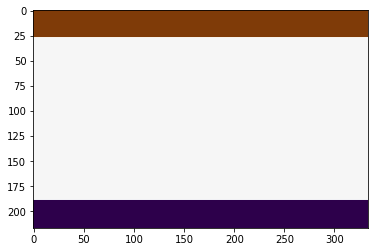

In [2]:
start_img = torch.zeros(IMG_SIZE)
start_img[:IMG_SIZE[0] // 8, :] = -1
start_img[-IMG_SIZE[0] // 8:, :] = 1

plt.imshow(start_img, cmap='PuOr')

In [3]:
dataset = MyData(path_or_img='./CloC/00006.png', data_mode='path', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
dataset_list = [dataset]


In [4]:
model = Net(dataset_list=dataset_list, lr=1e-2, weight_decay=1e-3)
model.to(device)
model.pretrain(img_size=IMG_SIZE, num_epochs=5000)
model.save_state_dict('./pretrained_model.pt')

Pretraining:  20%|█▉        | 978/5000 [00:03<00:14, 283.87it/s]


KeyboardInterrupt: 

## Train

<All keys matched successfully>

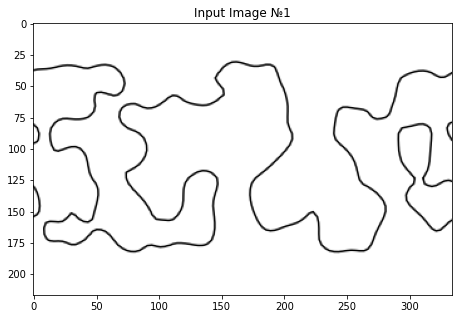

In [2]:
dataset = MyData(path_or_img='./CloC/00006.png', data_mode='path', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
dataset_list = [dataset]
dataset.show_image()

model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
model.to(device)

model.load_state_dict(torch.load('./pretrained_model.pt'))
# _ = model.test_model(threshold=0.15, need_plot=True)


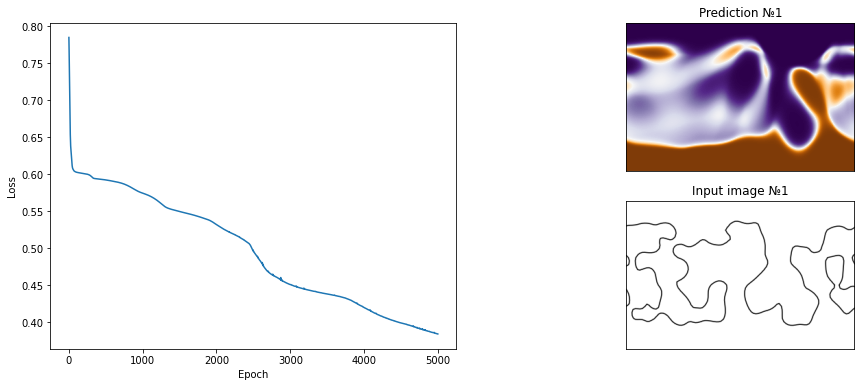

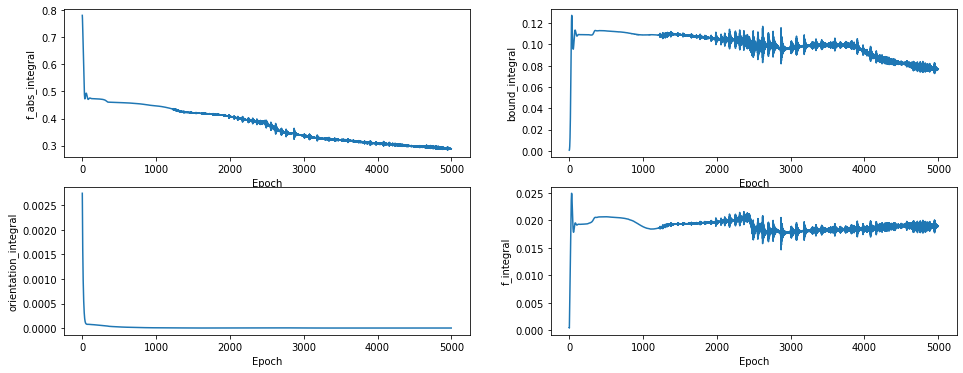

In [3]:
# model = model.restart_model(lr=1e-3)
model.start_training(num_epochs=5e+3, my_weight=0.1, need_save=False, need_plot=True)

In [3]:
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

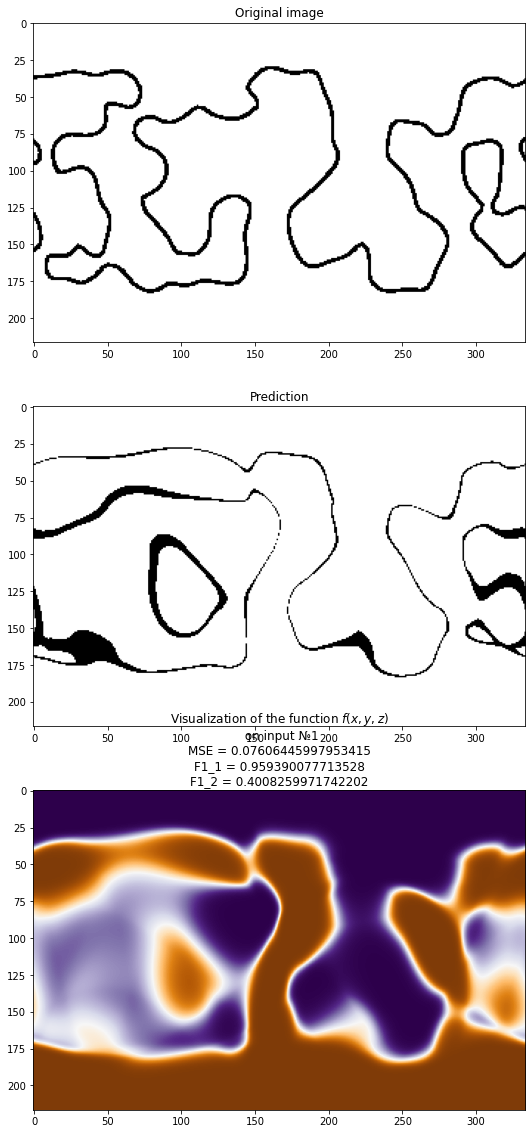

In [4]:
eps = 0.15
prediction_list, mse, f1, f2 = model.test_model(threshold=eps, need_plot=True)

In [11]:
model.save_state_dict('./model.pth')

## Test


### Training loop

In [9]:
# i want to create txt file with results
from tqdm import tqdm
with open('results.txt', 'w') as f:
    for path_to_img in tqdm(glob(PATH_TO_DATASET + '*.png')[:500]):
        f.write(f'{path_to_img[len(PATH_TO_DATASET):]}\n')
        for i in range(2):
            dataset = MyData(path_or_img=path_to_img, data_mode='path', mode_3d='cylinder', radius=1, reduce_fctor=1, need_info=False)
            dataset_list = [dataset]
            model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
            model.to(device)
            if not i:
                model.load_state_dict(torch.load('./pretrained_model.pt'))
            model.start_training(num_epochs=15e+3, my_weight=0.1, need_save=False, need_plot=False)
            mse, f1, f2 = model.test_model_(threshold=0.15)
            flag = f'Iteration {i+1}' if i else 'Pretrained Iteration 1'
            f.write(flag + f':\nMSE: {mse:.2f} F1: {f1:.2f}, {f2:.2f}\n\n')

 28%|██▊       | 139/500 [7:28:14<19:24:09, 193.49s/it]


KeyboardInterrupt: 

### Metrics analysis

In [ ]:
df = pd.DataFrame(columns=['name', 'mse_pretrained', 'f1_pretrained', 'f2_pretrained', 'mse_random', 'f1_random', 'f2_random'])
with open('results.txt', 'r') as f:
    for line in f:
        if line.endswith('.png\n'):
            name = line[:-1]
            df = df.append({'name': name}, ignore_index=True)
        elif line.startswith('Pretrained'):
            mse_pretrained = float(f.readline()[5:-1])
            f1_pretrained, f2_pretrained = f.readline()[4:-1].split(', ')
            df.loc[df.name == name, 'mse_pretrained'] = mse_pretrained
            df.loc[df.name == name, 'f1_pretrained'] = f1_pretrained
            df.loc[df.name == name, 'f2_pretrained'] = f2_pretrained
        elif line.startswith('Random'):
            mse_random = float(f.readline()[5:-1])
            f1_random, f2_random = f.readline()[4:-1].split(', ')
            df.loc[df.name == name, 'mse_random'] = mse_random
            df.loc[df.name == name, 'f1_random'] = f1_random
            df.loc[df.name == name, 'f2_random'] = f2_random
            
df.to_excel('results.xlsx', index=False)

In [10]:
df

,name,mse_pretrained,f1_pretrained,f2_pretrained,mse_random,f1_random,f2_random
0,00001.png,0.08,0.96,0.37,0.08,0.96,0.35
1,00002.png,0.07,0.96,0.45,0.08,0.96,0.38
2,00003.png,0.09,0.95,0.35,0.07,0.96,0.43
3,00004.png,0.08,0.96,0.38,0.1,0.95,0.34
4,00005.png,0.09,0.95,0.34,0.08,0.96,0.41
...,...,...,...,...,...,...,...
134,00135.png,0.08,0.96,0.37,0.05,0.97,0.49
135,00136.png,0.06,0.97,0.47,0.1,0.95,0.3
136,00137.png,0.08,0.96,0.42,0.08,0.95,0.38
137,00138.png,0.1,0.95,0.32,0.05,0.97,0.54


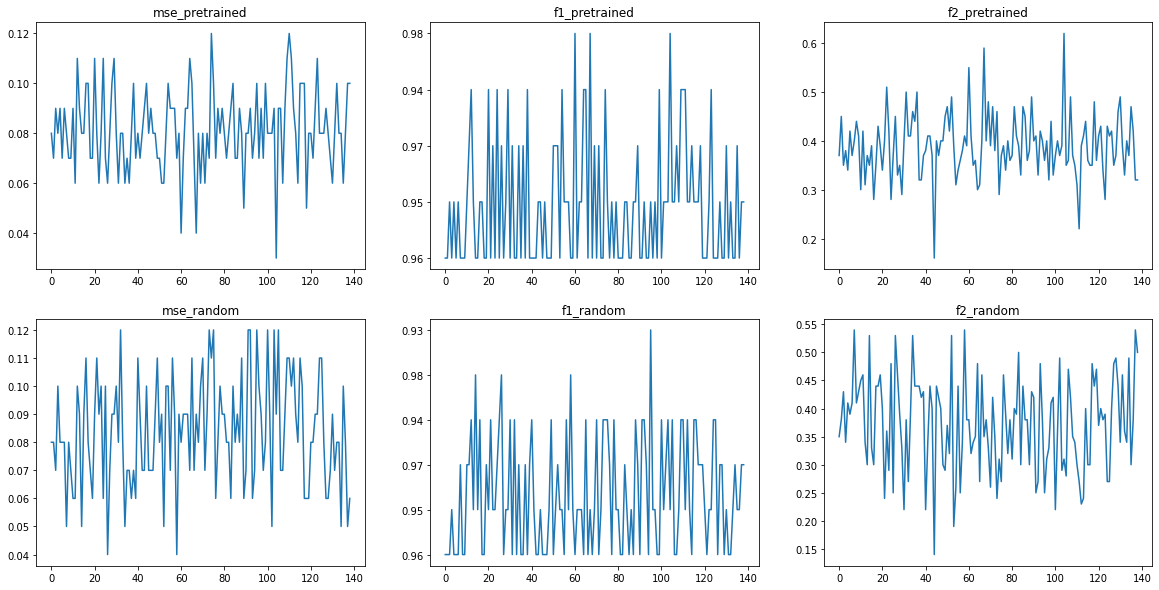

In [11]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(2, 3, i+1)
    plt.plot(df[col].values)
    plt.title(col)
plt.show()


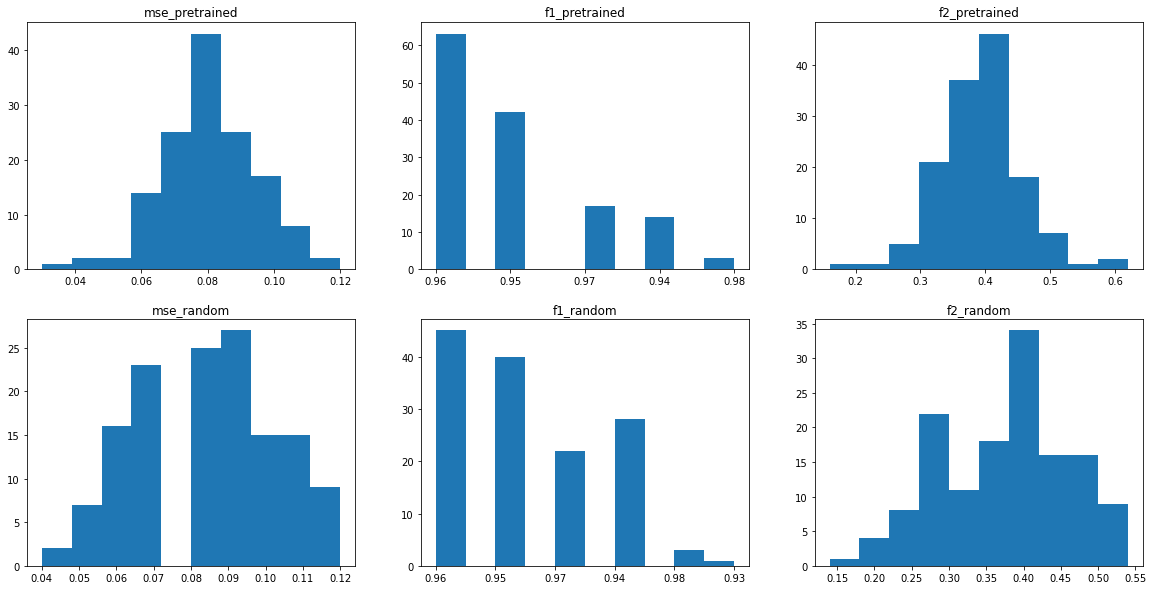

In [12]:
# plot histogram of mse, f1, f2
plt.figure(figsize=(20, 10))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(2, 3, i+1)
    plt.hist(df[col].values)
    plt.title(col)
plt.show()
